##### Copyright 2022 Sang Wook Kim.

In [3]:
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

In [4]:
import tensorflow as tf
print(tf.__version__)
# you may need the latest version of tensorflow

2.7.0


In [5]:
# Check if you have imageio. If you don't,
# !pip install imageio

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [8]:
# import imageio as iio
# im = iio.imread('./bed/00000001.jpg')
# print(im.shape)
# plt.imshow(im)

In [11]:
import cv2

(333, 500)


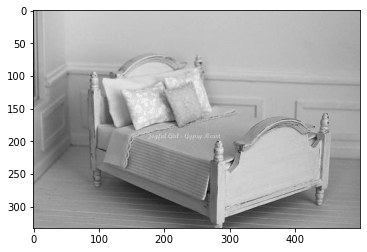

In [34]:
#check the image and see if it looks good
sample_grey = cv2.imread('./bed/00000001.jpg', cv2.IMREAD_GRAYSCALE)
print(sample_grey.shape)
plt.imshow(sample_grey, cmap=plt.get_cmap('gray'))

In [35]:
# check if the gray image scale
np.amax(img_grey)

220

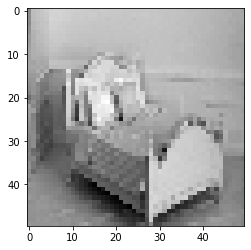

In [36]:
# resize it and see if it looks okay
sample_grey2 = cv2.resize(sample_grey, (50,50))
sample_grey2 = (sample_grey2 - 127.5) / 127.5  # Normalize the images to [-1, 1]
plt.imshow(sample_grey2, cmap=plt.get_cmap('gray'))

In [51]:
# load image set
# Source : https://www.kaggle.com/akkithetechie/furniture-detector
# License : CC0: Public Domain
base_dir = './bed'
imgs = []
img_shapes = (48,48)
for file in os.listdir(base_dir):
    file_path = f"{base_dir}/{file}"
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # read in grayscale
    img = cv2.resize(img, img_shapes) # resize into 50,50
    img = (img - 127.5) / 127.5 # Normalize the image
    imgs.append(img)

In [52]:
imgs = np.asarray(imgs)
print(imgs.shape)

(1000, 48, 48)


In [53]:
import random

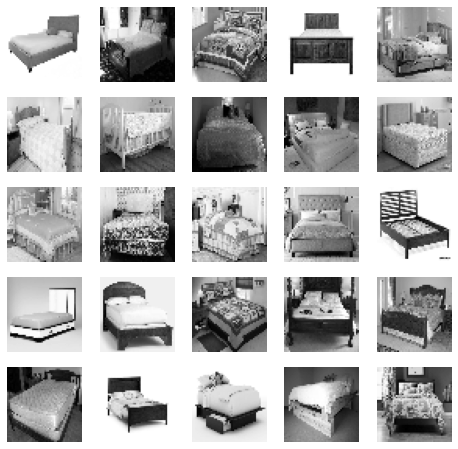

In [54]:
# Here are some images in the dataset
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(imgs[random.randint(0,1000)],cmap=plt.get_cmap('gray'))
        ax[i,j].axis('off')

In [92]:
params = {'batch_size': 20, 
          'noise_dims':100}
train_dataset = tf.data.Dataset.from_tensor_slices(imgs).batch(params['batch_size'])

### Generator

In [93]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*12*256, use_bias=False, input_shape=(params['noise_dims'],)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((12, 12, 256)))
    assert model.output_shape == (None, 12, 12, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 48, 1)

    return model
# tip: option padding='same' tries to give you same resolution if strides = 1.

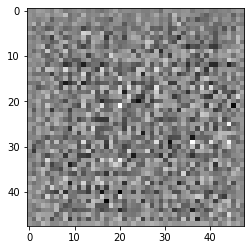

In [94]:
# untrained generator
generator = make_generator_model()

noise = tf.random.normal([1, params['noise_dims']])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

In [95]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[img_shapes[0], img_shapes[1], 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [96]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00162019]], shape=(1, 1), dtype=float32)


In [97]:
# function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [98]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [99]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [100]:
# define separate optimi
generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

### Save checkpoints

In [101]:
checkpoint_dir = './savepoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cpoint")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training loop

In [102]:
EPOCHS = 50
BATCH_SIZE = params['batch_size']
noise_dim = params['noise_dims']
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
pre_generated = tf.random.normal([num_examples_to_generate, noise_dim])

In [103]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [104]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 pre_generated)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               pre_generated)

In [105]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./fig/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Train the model

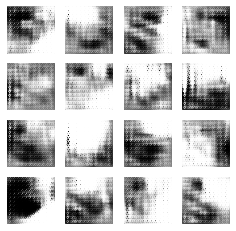

In [106]:
train(train_dataset, EPOCHS)

### Animated gif

In [107]:
anim_file = './fig/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./fig/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

### There are a lot of aspects to improve such as model and training process